In [29]:
# Import Libraries

import numpy as np
import cv2
import matplotlib.pyplot as plt
import copy


In [30]:
# Read the image

testImage = cv2.imread('./Data/Logs-860x360.jpg')

In [23]:
# Apply Canny after smoothing the image
minVal= 100
maxVal= 200
blur = cv2.blur(testImage,(5,5))
edges = cv2.Canny(blur, minVal, maxVal, 3, L2gradient=True)

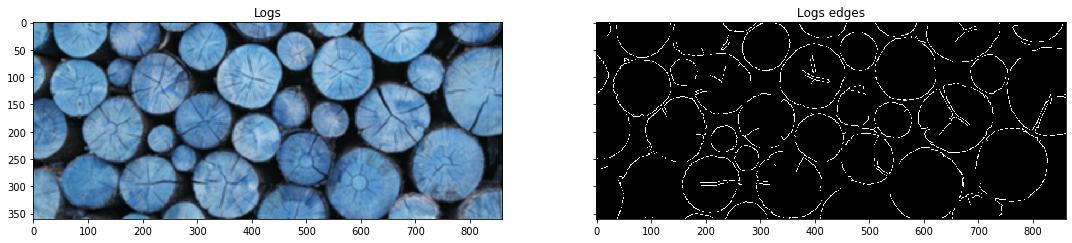

In [24]:
#Plot the blurred image alongside the edge image
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
f.set_size_inches(18.5, 10.5)
ax1.set_title('Logs')
ax1.imshow(blur, cmap='gray')


ax2.set_title('Logs edges')
#plt.imsave('logs-canny.png', edges, cmap='gray', format='png')
ax2.imshow(edges, cmap='gray')


In [31]:
# Count the number of contours and overlay the contours on the image
contours, hierarchy = cv2.findContours(edges,
    cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

#cv2.imshow('Canny Edges After Contouring', edged)
#cv2.waitKey(0)

print("Number of Contours found = " + str(len(contours)))
testImageDeepCopy = copy.deepcopy(testImage)
testImageContoured = cv2.drawContours(testImageDeepCopy, contours, -1, (0, 255, 0), 3)

Number of Contours found = 119


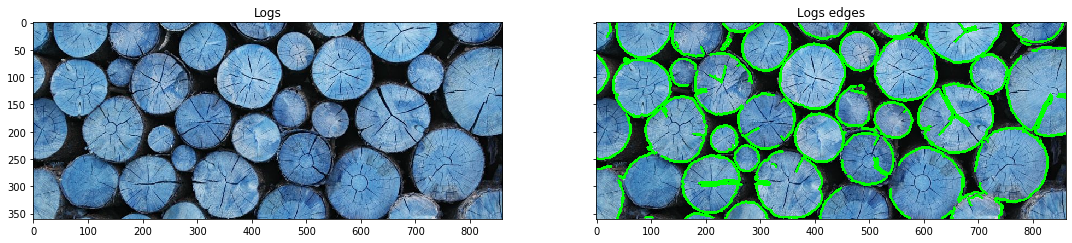

In [32]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
f.set_size_inches(18.5, 10.5)
ax1.set_title('Logs')
ax1.imshow(testImage, cmap='gray')


ax2.set_title('Logs edges')
#plt.imsave('logs-canny.png', edges, cmap='gray', format='png')
ax2.imshow(testImageContoured)

As we can see from above, even with blurring the image, we still end up with a wrong estimate for the number of logs as it fails to eliminate strong crevices in the wood, the log surface is uneven which causes multiple breaks in the contour, some true log edges are now missing on the darker regions.